In [1]:
# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
import pyspark
from pyspark import SparkContext
from pyspark.sql import functions as f
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType, BooleanType, ArrayType, StringType

#Spark NLP
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

# Helpers
import os

In [3]:
conf = pyspark.SparkConf().setMaster("local[*]").setAll([
    ('spark.driver.memory','16G'),
    ('spark.driver.maxResultSize', '8G'),
    ('spark.sql.execution.arrow.pyspark.enabled', True),
    ('spark.local.dir', '/tmp')
])

spark = SparkSession.builder.config(conf=conf).config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.2").getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")
spark


In [4]:
DATA_DIR = 'data/'
QUOTEBANK_DATA_DIR = DATA_DIR + 'quotebank_data_raw/'

In [5]:
speaker_attribs = pd.read_parquet(DATA_DIR + 'qb_data.parquet')
speaker_attribs = speaker_attribs.set_index('id')

In [6]:
attrib_labels = pd.read_csv('data/wikidata_labels_descriptions_quotebank.csv.bz2')
attrib_labels = attrib_labels.set_index("QID")

#df_attrib = spark.read.parquet(DATA_DIR + 'qb_data.parquet')

In [7]:
dfs = []
for i in os.listdir(QUOTEBANK_DATA_DIR):
    dfs.append(spark.read.json(QUOTEBANK_DATA_DIR + i))

In [8]:
df = dfs[0]
for df_part in dfs[1:]:
    df = df.union(df_part)

In [10]:
kw_econ = ["economy", "economic"]

def topic_match(q, kws):
    q = q.lower()
    for kw in kws:
        if kw in q: return True
    return False

# User defined function for mapping a column to True/False based on whether the column
# contains the keywords related to economy
@f.udf(returnType=BooleanType())
def econ_topic_match(q):
    return topic_match(q, kw_econ)

# User defined function for mapping a column to True/False based on whether the column
# is null/empty list
@f.udf(returnType=BooleanType())
def is_empty(val_list):
    return val_list is None or len(val_list) == 0

In [11]:
df_has_speaker = df.where(df.speaker != "None").where(~is_empty(df.qids))
df_has_speaker.count()

3443605

In [12]:
df_econ = df_has_speaker.where(econ_topic_match(df_has_speaker.quotation))
df_econ.count()

45953

In [13]:
df_econ_pd = df_econ.toPandas()

In [14]:
def speaker_to_occupation(qid):
    """Return the label associated with a qid or None if not available."""
    if qid in speaker_attribs.index:
        return speaker_attribs.occupation[qid]
    return None

In [15]:
df_econ_pd["occupation"] = df_econ_pd.qids.apply(lambda val : speaker_to_occupation(val[0]))

In [16]:
def qid_to_label(qid):
    """Return the label associated with a qid or None if not available."""
    if qid in attrib_labels.index:
        return attrib_labels.Label[qid]
    return None
    
def map_list(fn, values):
    if values is not None:
        return list(map(fn, values))
    return []

In [17]:
df_econ_pd["occupation_labels"] = df_econ_pd.occupation.apply(lambda val : map_list(qid_to_label, val))

In [18]:
df_econ_pd.head()

,date,numOccurrences,phase,probas,qids,quotation,quoteID,speaker,urls,occupation,occupation_labels
0,2020-01-22 09:14:24,2,E,"[[Lim Guan Eng, 0.9581], [None, 0.0419]]",[Q707164],Coupled with solid institutions as measured by...,2020-01-22-015396,Lim Guan Eng,[http://www.themalaymailonline.com/news/money/...,[Q82955],[politician]
1,2020-04-03 22:00:00,1,E,"[[Frank Pavone, 0.5178], [None, 0.2799], [Pres...",[Q5488928],economy and the free market from the threat of...,2020-04-03-012199,Frank Pavone,[http://catholicnewsagency.com/news/catholics-...,[Q36180],[writer]
2,2020-03-18 13:00:00,17,E,"[[Philip Lowe, 0.8229], [None, 0.0994], [Matt ...","[Q1981766, Q27922677]",having a very major impact on the economy and ...,2020-03-18-019177,Philip Lowe,[https://www.byronnews.com.au/news/cba-slammed...,[Q188094],[economist]
3,2020-01-02 00:00:00,1,E,"[[Steve Bartlett, 0.9232], [None, 0.0754], [Pr...",[Q185480],I enjoy your analysis and instruction on polli...,2020-01-02-019876,Steve Bartlett,[http://feeds.foxnews.com/~r/foxnews/politics/...,"[Q82955, Q11986654]","[politician, lobbyist]"
4,2020-04-03 14:03:00,2,E,"[[Ursula von der Leyen, 0.9706], [None, 0.0294]]",[Q60772],invest whatever is necessary to have the econo...,2020-04-03-031101,Ursula von der Leyen,[http://express.co.uk/news/uk/1264562/eu-news-...,"[Q39631, Q82955, Q2730732]","[physician, politician, equestrian]"


In [19]:
def freq_count(vals, counts):
    if vals is None: return
    for val in vals:
        if val not in counts: counts[val] = 0
        counts[val] += 1

In [20]:
econ_quotes_by_profession = {}
df_econ_pd.occupation_labels.apply(lambda vals: freq_count(vals, econ_quotes_by_profession));

In [21]:
kvs = sorted(list(econ_quotes_by_profession.items()), key = lambda x : x[1], reverse=True)

<AxesSubplot:>

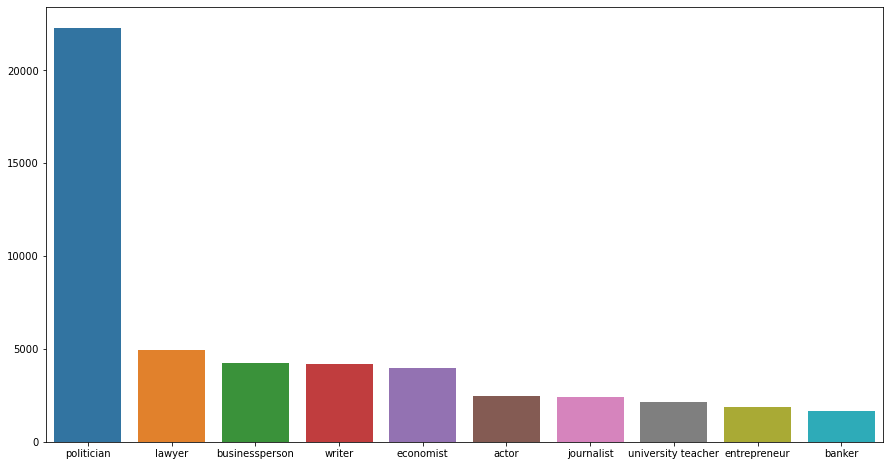

In [22]:
top_10_for_econ = kvs[:10]
plt.figure(figsize=(15,8))
sns.barplot(x=[x for x,y in top_10_for_econ], y=[y for x,y in top_10_for_econ])